In [ ]:
'''
【项目07】  城市餐饮店铺选址分析

1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
提示：
① 数据清洗，清除空值、为0的数据
② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
   * 这里排除了高端奢侈餐饮的数据干扰
⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标西，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
提示：
① 道路密度指标计算方法 → 网格内道路长度
② 餐饮热度指标计算方法 → 网格内餐饮poi计数
③ 同类竞品指标计算方法 → 网格内素菜馆poi计数
④ 餐饮poi数据记得投影
⑤ 可以以“net_population.shp”为网格基础数据，做空间统计
⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等
⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值
⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分


'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [ ]:
'''
1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
提示：
① 数据清洗，清除空值、为0的数据
② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
   * 这里排除了高端奢侈餐饮的数据干扰
⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

'''

In [2]:
# 查看数据

import os
os.chdir('C:\\Users\\Hjx\\Desktop\\')
# 创建工作路径

df1 = pd.read_excel('上海餐饮数据.xlsx',sheetname=0,header=0)
df1_length = len(df1)
df1_columns = df1.columns.tolist()
print('数据量为%i条' % len(df1))
print(df1.head())

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\Hjx\\Desktop\\'

,口味,口味_norm,人均消费,人均消费_norm,性价比,性价比_norm
类别,,,,,,
甜点,7.524346,0.299533,30.706620,0.037987,1.071627,1.000000
快餐,7.361730,0.070508,25.996115,0.000000,1.014229,0.937130
面馆,7.505263,0.272656,27.947368,0.015735,0.921746,0.835829
常菜,7.311667,0.000000,46.258333,0.163400,0.611388,0.495883
疆菜,7.791221,0.675392,59.610687,0.271077,0.611234,0.495714


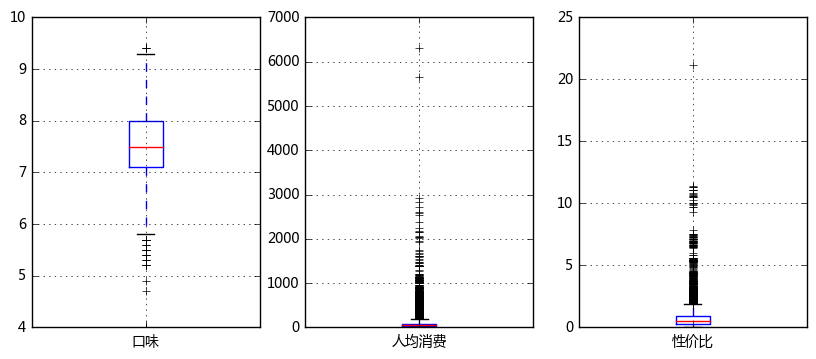

In [3]:
# 口味、客单价、性价比指标计算

data1 = df1[['类别','口味','环境','服务','人均消费']]
data1.dropna(inplace = True)
data1 = data1[(data1['口味']>0)&(data1['人均消费']>0)]
# 筛选数据，清除空值、为0的数据

data1['性价比'] = (data1['口味'] + data1['环境'] + data1['服务']) / data1['人均消费']
# 计算性价比指数

fig,axes = plt.subplots(1,3,figsize = (10,4))
data1.boxplot(column=['口味'],ax = axes[0])
data1.boxplot(column=['人均消费'],ax = axes[1])
data1.boxplot(column=['性价比'],ax = axes[2])
# 查看异常值

def f1(data,col):
    q1 = data[col].quantile(q = 0.25)
    q3 = data[col].quantile(q = 0.75) 
    iqr = q3-q1
    t1 = q1 - 3 * iqr
    t2 = q3 + 3 * iqr
    return data[(data[col] > t1)&(data[col]<t2)][['类别',col]]
# 创建函数 → 删除异常值

data_kw = f1(data1,'口味')
data_rj = f1(data1,'人均消费')
data_xjb = f1(data1,'性价比')
# 数据异常值处理

def f2(data,col):
    col_name = col + '_norm'
    data_gp = data.groupby('类别').mean()
    data_gp[col_name] = (data_gp[col] - data_gp[col].min())/(data_gp[col].max()-data_gp[col].min())
    data_gp.sort_values(by = col_name, inplace = True, ascending=False)
    return data_gp
# 创建函数 → 标准化指标并排序

data_kw_score = f2(data_kw,'口味')
data_rj_score = f2(data_rj,'人均消费')
data_xjb_score = f2(data_xjb,'性价比')
# 指标标准化得分

data_final_q1 = pd.merge(data_kw_score,data_rj_score,left_index=True,right_index=True)    # 合并口味、人均消费指标得分
data_final_q1 = pd.merge(data_final_q1,data_xjb_score,left_index=True,right_index=True)       # 合并性价比指标得分
# 合并数据

data_final_q1.head()

In [4]:
# 制作散点图、柱状图
# x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”

from bokeh.models import HoverTool
from bokeh.palettes import brewer
from bokeh.models.annotations import BoxAnnotation
from bokeh.layouts import gridplot
# 导入模块

data_final_q1['size'] = data_final_q1['口味_norm'] * 40  # 添加size字段
data_final_q1.index.name = 'type'
data_final_q1.columns = ['kw','kw_norm','price','price_norm','xjb','xjb_norm','size']
# 将中文改为英文
# 添加颜色参数

source = ColumnDataSource(data_final_q1)
# 创建ColumnDataSource数据

hover = HoverTool(tooltips=[("餐饮类型", "@type"),
                            ("人均消费", "@price"),
                            ("性价比得分", "@xjb_norm"),
                            ("口味得分", "@kw_norm")
                           ])  # 设置标签显示内容
result = figure(plot_width=800, plot_height=250,
                title="餐饮类型得分情况" ,
                x_axis_label = '人均消费', y_axis_label = '性价比得分', 
                tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair']) 
# 构建绘图空间
result.circle(x = 'price',y = 'xjb_norm',source = source,
         line_color = 'black',line_dash = [6,4],fill_alpha = 0.6,
        size = 'size')
price_mid = BoxAnnotation(left=40,right=80, fill_alpha=0.1, fill_color='navy')   
result.add_layout(price_mid)
# 设置人均消费中间价位区间
result.title.text_font_style = "bold"
result.ygrid.grid_line_dash = [6, 4]
result.xgrid.grid_line_dash = [6, 4]
# 散点图

# 绘制柱状图
data_type = data_final_q1.index.tolist()# 提取横坐标

kw = figure(plot_width=800, plot_height=250, title='口味得分',x_range=data_type,
           tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
kw.vbar(x='type', top='kw_norm', source=source,width=0.9, alpha = 0.8,color = 'red')   
kw.ygrid.grid_line_dash = [6, 4]
kw.xgrid.grid_line_dash = [6, 4]
# 柱状图1

price = figure(plot_width=800, plot_height=250, title='人均消费得分',x_range=kw.x_range,
              tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
price.vbar(x='type', top='price_norm', source=source,width=0.9, alpha = 0.8,color = 'green') 
price.ygrid.grid_line_dash = [6, 4]
price.xgrid.grid_line_dash = [6, 4]
# 柱状图2
    
p = gridplot([[result],[kw], [price]])
# 组合图表
show(p)

In [ ]:
'''
2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标西，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
提示：
① 道路密度指标计算方法 → 网格内道路长度
② 餐饮热度指标计算方法 → 网格内餐饮poi计数
③ 同类竞品指标计算方法 → 网格内素菜馆poi计数
④ 餐饮poi数据记得投影
⑤ 可以以“net_population.shp”为网格基础数据，做空间统计
⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等
⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值
⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分

'''

In [5]:
# 加载数据

df2 = pd.read_excel('空间统计.xlsx',sheetname=0,header=0)
data2 = df2.fillna(0)
data2.head()

,人口密度,餐饮计数,素菜餐饮计数,道路长度,id,lng,lat
0,0,0.0,0.0,0.000000,1,121.273114,30.685411
1,0,0.0,0.0,128.477758,2,121.262516,30.694291
2,0,0.0,0.0,1539.908057,3,121.272953,30.694430
3,0,0.0,0.0,1032.299541,4,121.283390,30.694569
4,0,0.0,0.0,1543.891782,5,121.293827,30.694706


In [6]:
# 指标统计

data2['rkmd_norm'] = (data2['人口密度']-data2['人口密度'].min())/(data2['人口密度'].max()-data2['人口密度'].min()) # 人口密度指标标准化
data2['cyrd_norm'] = (data2['餐饮计数']-data2['餐饮计数'].min())/(data2['餐饮计数'].max()-data2['餐饮计数'].min()) # 餐饮热度指标标准化
data2['tljp_norm'] = (data2['素菜餐饮计数'].max()-data2['素菜餐饮计数'])/(data2['素菜餐饮计数'].max()-data2['素菜餐饮计数'].min()) # 同类竞品指标标准化
data2['dlmi_norm'] = (data2['道路长度']-data2['道路长度'].min())/(data2['道路长度'].max()-data2['道路长度'].min()) # 道路密度指标标准化
# 指标标准化

data2['final_score'] = data2['rkmd_norm']*0.4 + data2['cyrd_norm']*0.3 + data2['tljp_norm']*0.1 + data2['dlmi_norm']*0.2
data_final_q2 = data2.sort_values(by = 'final_score',ascending=False).reset_index()
data_final_q2[:10]
# 计算综合评分并查看TOP10的网格ID

,index,人口密度,餐饮计数,素菜餐饮计数,道路长度,id,lng,lat,rkmd_norm,cyrd_norm,tljp_norm,dlmi_norm,final_score
0,4372,35036,1244.0,2.0,15483.180214,4373,121.473117,31.238244,0.820688,1.000000,0.846154,0.528626,0.818616
1,4303,36929,1186.0,2.0,9309.285084,4304,121.473262,31.229224,0.865030,0.953376,0.846154,0.317837,0.780208
2,4301,36929,1049.0,3.0,14010.454617,4302,121.452270,31.228973,0.865030,0.843248,0.769231,0.478344,0.771578
3,4163,36929,895.0,3.0,14432.974864,4164,121.463058,31.211059,0.865030,0.719453,0.769231,0.492770,0.737325
4,4232,36929,972.0,4.0,12104.466337,4233,121.452417,31.219953,0.865030,0.781350,0.692308,0.413270,0.732302
5,4642,42691,504.0,0.0,11962.381378,4643,121.472536,31.274322,1.000000,0.405145,1.000000,0.408419,0.703227
6,4234,35036,803.0,3.0,14047.248280,4235,121.473408,31.220204,0.820688,0.645498,0.769231,0.479601,0.694768
7,4373,35036,789.0,0.0,9234.584203,4374,121.483615,31.238368,0.820688,0.634244,1.000000,0.315287,0.681606
8,4576,42691,403.0,0.0,11847.624492,4577,121.483182,31.265427,1.000000,0.323955,1.000000,0.404501,0.678087
9,4441,40623,362.0,0.0,14089.364209,4442,121.483471,31.247388,0.951559,0.290997,1.000000,0.481038,0.664130


In [7]:
# 制作空间散点图

data_final_q2['size'] = data_final_q2['final_score'] * 20
data_final_q2['color'] = 'green'
data_final_q2['color'].iloc[:10] = 'red'
# 添加size字段

source = ColumnDataSource(data_final_q2)
# 创建ColumnDataSource数据

hover = HoverTool(tooltips=[("经度", "@lng"),
                            ("纬度", "@lat"),
                            ("最终得分", "@final_score"),
                           ])  # 设置标签显示内容
p = figure(plot_width=800, plot_height=800,
                title="空间散点图" , 
                tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair']) 
# 构建绘图空间

p.square(x = 'lng',y = 'lat',source = source,
         line_color = 'black',fill_alpha = 0.5,
        size = 'size',color = 'color')
p.ygrid.grid_line_dash = [6, 4]
p.xgrid.grid_line_dash = [6, 4]
# 散点图
show(p)